# 1 - NBoW

In this series we'll be building a machine learning model to perform sentiment analysis -- a subset of text classification where the task is to detect if a given sentence is positive or negative -- using [PyTorch](https://github.com/pytorch/pytorch) and [torchtext](https://github.com/pytorch/text). The dataset used will be movie reviews from the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which we'll obtain using the [datasets](https://github.com/huggingface/datasets) library.

## Introduction

In this first notebook, we'll start very simple with one of the most basic models for *NLP* (natural language processing): a *NBoW* (*neural bag-of-words*) model (also known as *continuous bag-of-words*, *CBoW*). The NBoW model are a strong, commonly used, baseline model for NLP tasks. They should be one of the first models you implement when performing sentiment analysis/text classification.

![](assets/nbow_model.png)

An NBoW model takes in a sequence of $T$ *tokens*, $X=\{x_1,...,x_T\} \in \mathbb{Z}^T$ and passes each token through an *embedding layer* to obtain a sequence of *embedding vectors*. The sequence of embedding vectors is just known as an *embedding*, $E=\{e_1,...,e_T\} \in \mathbb{R}^{T \times D}$, where $D$ is known as the *embedding dimension*. It then *pools* the embeddings across the sequence dimension to get $P \in \mathbb{R}^D$ and then finally passes $P$ through a linear layer (also known as a fully connected layer), to get a prediction, $\hat{Y} \in \mathbb{R}^C$, where $C$ is the number of classes. We'll explain what a token is, and what each of the layers -- embedding layer, pooling, and linear layer -- do in due course. 

A note on notation, what does something like $E=\{e_1,...,e_T\} \in \mathbb{R}^{T \times D}$ mean? $\mathbb{R}^{T \times D}$ means a $T \times D$ sized tensor full of real numbers, i.e. a `torch.FloatTensor`. $X=\{x_1,...,x_T\} \in \mathbb{Z}^T$ is a $T$ sized tensor full of integers, i.e. a `torch.LongTensor`.

## Preparing Data

Before we can implement our NBoW model, we first have to perform quite a few steps to get our data ready to use. NLP usually requires quite a lot of data wrangling beforehand, though libraries such as `datasets` and `torchtext` handle most of this for us.

The steps to take are:
- importing modules
- loading data
- tokenizing data
- creating data splits
- creating a vocabulary
- numericalizing data
- creating the dataloaders

### Importing Modules

First, we'll import the required modules. 

We use the `datasets` module for handling datasets, `matplotlib` for plotting our results, `numpy` for numerical analysis, `torch` for tensor computations, `torch.nn` for neural networks, `torch.optim` for neural network optimizers, `torchtext` for text processing, and `tqdm` for process bars.

In [1]:
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

/home/payetquentin/Documents/workspace/briefs/s13_notebook/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll also make sure to set the random seeds for `torch` and `numpy`. This is to ensure this notebook is reproducable, i.e. we get the same results each time we run it.

It is usually good practice to run your experiments multiple times with different random seeds -- both to measure the variance of your model and also to avoid having results only calculated with either "good" or "bad" seeds, i.e. being very lucky or unlucky with the randomness in the training process.

In [2]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

Next, we'll load our dataset using the `datasets` library. The first argument is the name of the dataset and the `split` argument chooses which *splits* of the data we want. 

Datasets usually come in two or more *splits*, non-overlapping examples from the data, most commonly a *train split* -- which we train our model on -- and a *test split* -- which we evaluate our trained model on. There's also a *validation split*, which we'll talk more about later. The train, test and validation split are also commonly called the train, test and validation sets -- we'll use split and set interchangeably
 in these tutorials -- and the dataset usually refers to all three of the sets combined. The IMDb dataset actually comes with a third split, called *unsupervised*, which contains a bunch of examples without labels. We don't want these so we don't include them in our `split` argument. Note that if we didn't pass an argument to `split` then it would load all available splits of the data.

How do we know that we have to use "imdb" for the IMDb dataset and that there's an "unsupervised" split? The `datasets` library has a great website used to browse the available datasets, see: https://huggingface.co/datasets/. By navigating to the [IMDb dataset page](https://huggingface.co/datasets/imdb) we can see more information specifically about the IMDb dataset.

The output received when loading the dataset tells us that it is using a locally cached version instead of downloading the dataset from online.

In [3]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

We can print out the splits which shows us the *features* and *num_rows* of the dataset. num_rows are the number of examples in split, as we can see, there are 25,000 examples in each. Each example in a dataset provided by the `datasets` library is a dictionary, and the features are the keys which appear in every one of those dictionaries/examples. So, each example in the IMDb dataset has a *text* and a *label* key.

In [4]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

We can check the `features` attribute of a split to get more information about the features. We can see that *text* is a `Value` of `dtype=string` -- in other words, it's a string -- and that *label* is a `ClassLabel`. A `ClassLabel` means the feature is an integer representation of which class the example belongs to. `num_classes=2` means that our labels are one of two values, 0 or 1, and `names=['neg', 'pos']` gives us the human-readable versions of those values. Thus, a label of 0 means the example is a negative review and a label of 1 means the example is a positive review.

In [5]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

We can look at an example by indexing into the train set. As we can see, the text is quite noisy and also rambles on quite a bit.

In [6]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

One of the first things we need to do to our data is *tokenize* it. Machine learning models aren't designed to handle strings, they're design to handle numbers. So what we need to do is break down our string into individual *tokens*, and then convert these tokens to numbers. We'll get to the conversion later, but first we'll look at *tokenization*.

Tokenization involves using a *tokenizer* to process the strings in our dataset. A tokenizer is a function that goes from a string to a list of strings. There are many types of tokenizers available, but we're going to use a relatively simple one provided by `torchtext` called the `basic_english` tokenizer. We load our tokenizer as such:

In [7]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

We can use the tokenizer by calling it on a string.

Notice it creates a token by splitting the word on spaces, puts punctuation as its own token, and also lowercases every single word.

The `get_tokenizer` function also supports other tokenizers, such as ones provided by [spaCy](https://spacy.io/) and [nltk](https://www.nltk.org/). 

In [8]:
tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

['hello',
 'world',
 '!',
 'how',
 'are',
 'you',
 'doing',
 'today',
 '?',
 'i',
 "'",
 'm',
 'doing',
 'fantastic',
 '!']

Now we have our tokenizer defined, we want to actually tokenize our data.

Each dataset provided by the `datasets` library is an instance of a `Dataset` class. We can see all the methods in a `Dataset` [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html#dataset), but the main one we are interested in is [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map). By using `map` we can apply a function to every example in the dataset and either update the example or create a new feature.

We define the `tokenize_example` function below which takes in an `example`, a `tokenizer` and a `max_length` argument, tokenizes the text in the example, given by `example['text']`, trims the tokens to a maximum length and then returns a dictionary with the new feature name and feature value for that example. Note that the first argument to a function which we are going to `map` must always be the example dictionary, and it must always return a dictionary where the keys are the feature names and the values are the feature values to be added to this example. 

We're trimming the tokens to a maximum length here as some examples are unnecessarily long and we can predict sentiment pretty well just using the first couple of hundred tokens -- though this might not be true for you if you're using a different dataset!

In [9]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    return {'tokens': tokens}

We apply the `tokenize_example` function below, on both the train and test sets. Any arguments to the function -- that aren't the example -- need to be passed as the `fn_kwargs` dictionary, with the keys being the argument names and the values the value passed to that argument.

Operations on a `Dataset` are **not** performed in-place. You should always return the result into a new variable.

Note the warnings showing that as I have performed this `map` before, the results are cached and are thus loaded from the cache instead of being calculated again.

In [10]:
max_length = 256

train_data = train_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

We can now see that our `train_data` has a *tokens* feature -- as "tokens" was a key in the dictionary returned by the function we used for the `map`.

In [11]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

By looking at the `features` attribute we can see it has automatically added the information about the tokens feature -- each is a sequence (a list) of strings. A `length=-1` means that all of our token sequences are not the same length.

In [12]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

We can check the first example in our train set to see the result of the tokenization:

In [13]:
train_data[0]['tokens'][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

Next up, we'll create a *validation set* from our data. This is similar to our test set in that we do not train our model on it, we only evaluate our model on it. 

Why have both a validation set and a test set? Your test set respresents the real world data that you'd see if you actually deployed this model. You won't be able to see what data your model will be fed once deployed, and your test set is supposed to reflect that. Every time we tune our model hyperparameters or training set-up to make it do a bit better on the test set, we are leak information from the test set into the training process. If we do this too often then we begin to overfit on the test set. Hence, we need some data which can act as a "proxy" test set which we can look at more frequently in order to evaluate how well our model actually does on unseen data -- this is the validation set.

We can split a `Dataset` using the `train_test_split` method which splits a dataset into two, creating a `DatasetDict` for each split, one called `train` and another called `test` -- a bit confusing because these are our train and validation sets, not the test. We use `test_size` to set the portion of the data used for the validation set -- 0.25 means we use 25% of the training set -- and the examples are chosen randomly.

In [14]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

By showing the lengths of each split within our dataset, we can see the 25,000 training examples have now been split into 18,750 training examples and 6,250 validation examples, with the original 25,000 test examples remaining untouched.

In [15]:
len(train_data), len(valid_data), len(test_data)

(18750, 6250, 25000)

In [16]:
min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [17]:
len(vocab)

21627

In [18]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [19]:
unk_index = vocab['<unk>']

unk_index

0

In [20]:
pad_index = vocab['<pad>']

pad_index

1

In [21]:
'some_token' in vocab

False

In [22]:
vocab.set_default_index(unk_index)

In [23]:
vocab['some_token']

0

In [24]:
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

In [25]:
train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})

Map:  12%|█▏        | 2304/18750 [00:00<00:06, 2494.06 examples/s]

Map: 100%|██████████| 25000/25000 [00:08<00:00, 2809.26 examples/s]


In [26]:
train_data[0]

{'text': 'Ya know when one looks at this Brian DePalma film today, I\'m sure there has been allot of criticism about how dated it is. Also, about the violence. When I looked at this film on VHS when I was 20, I thought it was ulta-violent and gritty as well. But I didn\'t get \'it\'.<br /><br />A few decades go by and man, how I know how much I didn\'t get in this film!! This is a remake of an excellent film which was done back in the 30\'s/40\'s. How can you improve upon a classic? Ya don\'t. But you tell a tale that is brought up to date through the eyes of the "new immigrants" during the most greed ridden decade, the over indulgent 80\'s. DePalma, Stone and the gang present an ambitious, disturbing and darn right good film.<br /><br />Yes....Disco was dying and New Wave/Punk were taking over but these immigrants from Cuba who had to make a new home in Florida couldn\'t tell the difference. It was exciting, it was what they wanted but how to get it???? To these immigrants, there was 

In [27]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

Same thing as `set_format`, but not in-place.

In [28]:
train_data[0]

{'label': tensor(1),
 'ids': tensor([ 4182,   130,    60,    34,   289,    37,    14,  1484,  8905,    23,
           503,     4,    12,     9,   145,   259,    46,    49,    87, 19432,
             7,  3213,    47,    91,  2000,    11,    10,     3,    97,     4,
            47,     2,   605,     3,    60,    12,   554,    37,    14,    23,
            27,  1634,    60,    12,    17,   934,     4,    12,   188,    11,
            17,     0,     6,  2358,    19,    81,     3,    22,    12,   163,
             9,    28,    88,     9,    11,     9,     3,     5,   174,  2537,
           150,    39,     6,   138,     4,    91,    12,   130,    91,    86,
            12,   163,     9,    28,    88,    13,    14,    23,    36,    36,
            14,    10,     5,   875,     7,    41,   299,    23,    73,    17,
           234,   155,    13,     2,   954,     9,     0,     9,    16,     3,
            91,    59,    26,  4464,   724,     5,   347,    56,  4182,    89,
             9,    28,  

In [29]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [30]:
batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

Use `output_all_columns=True` to keep non-converted columns.

In [31]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [32]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique('label'))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,488,702 trainable parameters


In [34]:
vectors = torchtext.vocab.FastText()

.vector_cache/wiki.en.vec: 6.60GB [07:41, 14.3MB/s]                                
100%|██████████| 2519370/2519370 [02:55<00:00, 14351.57it/s]


In [35]:
hello_vector = vectors.get_vecs_by_tokens('hello')

In [36]:
hello_vector.shape

torch.Size([300])

In [37]:
hello_vector

tensor([-1.5945e-01, -1.8259e-01,  3.3443e-02,  1.8813e-01, -6.7903e-02,
        -1.3663e-01, -2.5559e-01,  1.1000e-01,  1.7275e-01,  5.1971e-02,
        -2.3302e-02,  3.8866e-02, -2.4515e-01, -2.1588e-01,  3.5925e-01,
        -8.2526e-02,  1.2176e-01, -2.6775e-01,  1.0072e-01, -1.3639e-01,
        -9.2658e-02,  5.1837e-01,  1.7736e-01,  9.4878e-02, -1.8461e-01,
        -4.2829e-02,  1.4114e-02,  1.6811e-01, -1.8565e-01,  3.4976e-02,
        -1.0293e-01,  1.7954e-01, -5.2766e-02,  7.2047e-02, -4.2704e-01,
        -1.1616e-01, -9.4875e-03,  1.4199e-01, -2.2782e-01, -1.7292e-02,
         8.2802e-02, -4.4512e-01, -7.5935e-02, -1.4392e-01, -8.2461e-02,
         2.0123e-01, -9.5344e-02, -1.1042e-01, -4.6817e-01,  2.0362e-01,
        -1.7140e-01, -4.9850e-01,  2.8963e-01, -1.0305e-01,  2.0393e-01,
         5.2971e-01, -2.5396e-01, -5.1891e-01,  2.9941e-01,  1.7933e-01,
         3.0683e-01,  2.5828e-01, -1.8168e-01, -1.0225e-01, -1.1435e-01,
        -1.6304e-01, -1.2424e-01,  3.2814e-01, -2.3

In [38]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [39]:
pretrained_embedding.shape

torch.Size([21627, 300])

In [40]:
model.embedding.weight

Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506,  ...,  0.8200, -0.6332,  1.2948],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1483,  2.4187,  1.3279,  ..., -1.0328,  1.1305, -0.5703],
        ...,
        [-0.0043,  0.4097, -0.2973,  ...,  0.6319,  0.0847, -1.1920],
        [ 0.2745, -0.1768,  1.1788,  ...,  1.3290, -0.7914, -0.1686],
        [ 0.2854,  0.2572,  1.1334,  ..., -2.3543,  0.1198,  0.0115]],
       requires_grad=True)

In [41]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0653, -0.0930, -0.0176,  ...,  0.1664, -0.1308,  0.0354],
        ...,
        [-0.1280, -0.2391, -0.3717,  ..., -0.2025, -0.1138,  0.2572],
        [-0.2301, -0.1799, -0.2485,  ...,  0.5203,  0.6245,  0.1723],
        [-0.1864,  0.1123, -0.0476,  ..., -0.1827,  0.1741,  0.1033]])

In [42]:
model.embedding.weight.data = pretrained_embedding

In [43]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0653, -0.0930, -0.0176,  ...,  0.1664, -0.1308,  0.0354],
        ...,
        [-0.1280, -0.2391, -0.3717,  ..., -0.2025, -0.1138,  0.2572],
        [-0.2301, -0.1799, -0.2485,  ...,  0.5203,  0.6245,  0.1723],
        [-0.1864,  0.1123, -0.0476,  ..., -0.1827,  0.1741,  0.1033]],
       requires_grad=True)

In [44]:
optimizer = optim.Adam(model.parameters())

In [45]:
criterion = nn.CrossEntropyLoss()

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [47]:
model = model.to(device)
criterion = criterion.to(device)

In [50]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [48]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [49]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [51]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'nbow.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

training...:   8%|▊         | 3/37 [00:00<00:03, 10.06it/s]

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.91it/s]
epoch: 1
train_loss: 0.684, train_acc: 0.563
valid_loss: 0.672, valid_acc: 0.652
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.28it/s]
epoch: 2
train_loss: 0.651, train_acc: 0.710
valid_loss: 0.631, valid_acc: 0.717
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.87it/s]
epoch: 3
train_loss: 0.595, train_acc: 0.760
valid_loss: 0.570, valid_acc: 0.765
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.83it/s]
epoch: 4
train_loss: 0.524, train_acc: 0.803
valid_loss: 0.503, valid_acc: 0.809
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.85it/s]
epoch: 5
train_loss: 0.453, train_acc: 0.843
valid_loss: 0.445, valid_acc: 0.840
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 13.89it/s]
epoch: 6
train_loss: 0.395, train_acc: 0.869
valid_loss: 0.403, valid_acc: 0.856
evaluating...: 100%|██████████| 13/13 [00:00<00:00, 15.52it/s]
epoch: 7
train_loss: 0.350, train_acc: 0.884
valid_loss: 0.372, valid_acc

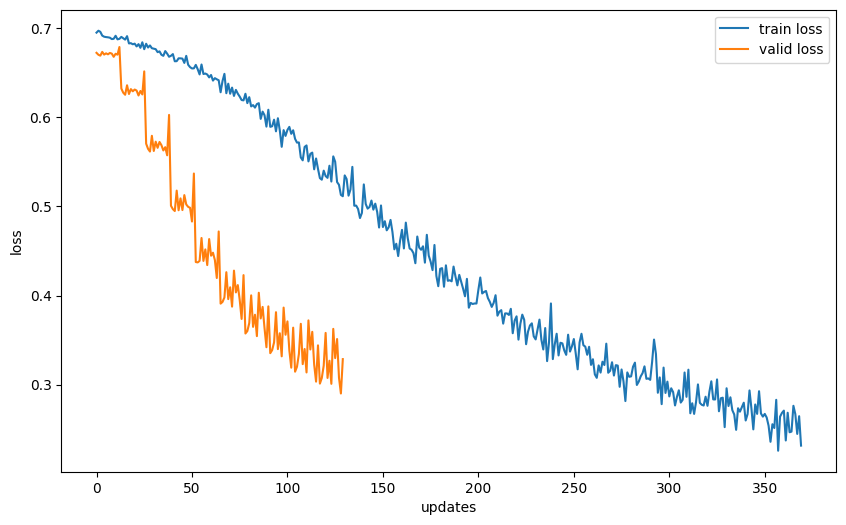

In [52]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

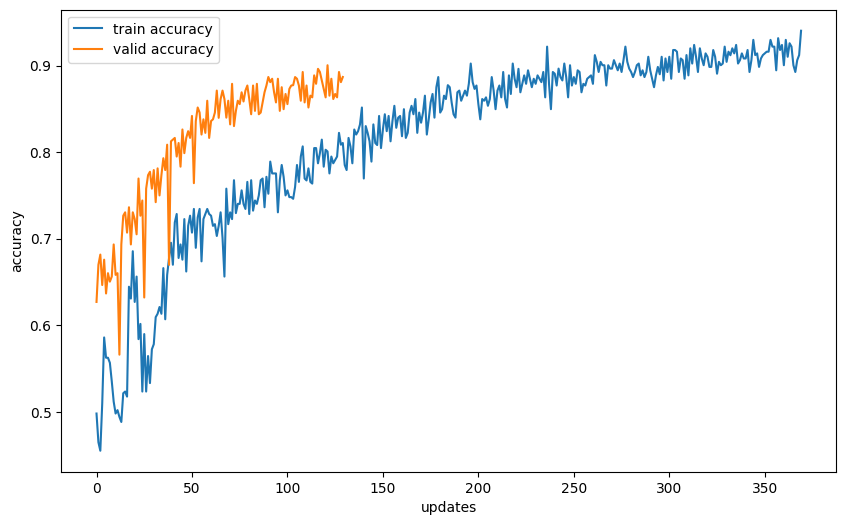

In [53]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [54]:
model.load_state_dict(torch.load('nbow.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...:   0%|          | 0/49 [00:00<?, ?it/s]

evaluating...: 100%|██████████| 49/49 [00:03<00:00, 13.58it/s]
test_loss: 0.354, test_acc: 0.857


In [55]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [56]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9999581575393677)

In [57]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9999995231628418)

In [58]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.8187904953956604)

In [59]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.8187904357910156)